<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Homework3" data-toc-modified-id="Homework3-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Homework3</a></span></li><li><span><a href="#Реализовать-с-помощью-объектно-ориентированного-подхода-предыдущие-2-задания.-Создайте-для-каждой-из-задач-отдельный-класс,-который-позволяет-ее-решить." data-toc-modified-id="Реализовать-с-помощью-объектно-ориентированного-подхода-предыдущие-2-задания.-Создайте-для-каждой-из-задач-отдельный-класс,-который-позволяет-ее-решить.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.</a></span></li></ul></div>

# Homework3
Школа DataScientist, декабрь 2022, Андреева Ольга

# Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"

Cохранить ее в pandas dataframe, а также в excel, pickle, БД

Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.

In [1]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# Класс для заполнения датафрейма
class BldObjects:

        def __init__(self, ):
            self.data=pd.DataFrame([])
 
        #функция для получения общего количества id-шников
        def getTotalCount():
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset=1&limit=1&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
            res = requests.get(url)
            return  res.json().get('data').get('total')

        #функция для чтения пачки id-шников
        def readIDs(p_offset, p_limit):
            c_http_success = 200
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={p_offset}&limit={p_limit}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
            res = requests.get(url)
            if res.status_code == c_http_success:
                try:
                    objects_data = res.json()
                    objects_list = objects_data.get('data').get('list')
                    return {'state': c_http_success, 'data':[x.get('objId') for x in objects_list]}
                except IndexError:
                    return({'state': c_http_success,'data': []});
                except Exception:
                    return({'state': '-1','data': []});


        #функция для чтения объекта по id-шнику
        def readObjectData (p_ObjID):
            # Для скачивания данных по определенному объекту, нужно добавить его id в конец строки запроса
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{p_ObjID}'
            res = requests.get(url)
            return res.json().get('data') 
        
        #наполнение датафрейма по http
        #если p_elements_count=0 - то читаем все данные
        def get_by_http(self, p_elements_count):
            c_http_success = 200
            v_offset = 1
            v_limit = 100
            lst_Objects=[]
            
            from datetime import datetime
            import time
            start_time = datetime.now()
            
            v_log_file_nm='reading_data_'+str(start_time)[0:10]+'.log'
            print(v_log_file_nm)
            
            v_log_file = open(v_log_file_nm,'w') 
            
            if p_elements_count==0:
                c_max_limit = BldObjects.getTotalCount()
            else: 
                c_max_limit=p_elements_count
                
            print ("must get: ", c_max_limit)

            while True:
                #обработка ограничения по количеству записей
                if v_offset + v_limit > c_max_limit:
                    v_limit = c_max_limit - v_offset + 1

                v_IDs_bath = BldObjects.readIDs(v_offset, v_limit) #cчитали порцию id-шников

                if v_IDs_bath.get('state') != c_http_success:
                    logging.debug(str(v_IDs_bath.get('state')) + "на " + str(v_offset) + "!")
                    print (v_IDs_bath.get('state'), "на ", v_offset, "!", file=v_log_file)
                else:
                    v_IDs=v_IDs_bath.get('data')
                    print(v_offset, " - code ", v_IDs_bath.get('state'), file=v_log_file)
                    #читаем каждый объект по ID
                    lst_Objects=[]
                    for i in (v_IDs):
                        try:
                            v_Object=BldObjects.readObjectData(i) 
                            lst_Objects.append(v_Object)
                        except Exception:
                            print("Не смог получить объект",str(i), "!", file=v_log_file)
                            continue;

                    #добавляем пачку объектов в датафрейм
                    self.data=self.data.append(pd.DataFrame(lst_Objects),ignore_index=True)     

                v_offset += v_limit
                print ("have got: ", v_offset-1)
                if len(v_IDs)<v_limit or v_offset>c_max_limit: break
            v_log_file.close()
            return ('Time: '+ str(datetime.now() - start_time))
        
        #чтение данных из excel
        def read_from_excel (self, file_name):
            from datetime import datetime
            import time
            start_time = datetime.now()
            
            self.data=pd.read_excel(file_name)
            
            return ('Time: '+ str(datetime.now() - start_time))
        
        #сохранение данных в excel
        def save_to_excel (self, file_name):    
            self.data.to_excel(file_name)            

In [3]:
#класс для очистки данных
class Clear_data:

        def __init__(self, df, map_columns):
                    #колонки, которые будем использовать в анализе
            self.map_objEnergy = dict({'A++':9, 'A+':8, 'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1, 'Не нормируется':0})
            self.map_LkClass = dict({'Другое':0,'Типовой':1, 'Комфорт':2, 'Бизнес':3, 'Элитный':4})

            #оставлю только интересные столбцы 
            self.data=df.loc[:,list(map_columns.keys())].copy()
        
        def be(self):
            print("qwer!")
        #преобразование высоты потолков в число

        def CeilingHeight_to_number(p_height):
            import re
            try:
                v_height=p_height.replace(',','.')
                res=re.findall('\d+(?:\.\d+)?', v_height)
                res=[float(n) for n in res]
                return max(res)   
            except ValueError:
                return None;
            except AttributeError:
                return None;
        
        #вычисление ближайшего растояния до метро
        def DistToMetro(p_sttn_list):
            try:
                v_sttns=[s.get('metroStationDistLength') for s in p_sttn_list]
                return min(v_sttns)
            except ValueError:
                return None;
            except AttributeError:
                return None;
        
       
        #преобразование типов
        def all_to_number(self):
            # от застройщика оставляю только ID и регион
            self.data['developer']=self.data['developer'].apply(eval)
            self.data['devId']=self.data['developer'].apply(lambda x: x.get('devId'))
            self.data['devRegion']=self.data['developer'].apply(lambda x: x.get('devOrgRegRegionCd'))
            self.data=self.data.drop('developer', axis=1)

            #от транспортной доступности оставляю расстояние до ближайшего метро
            self.data['objectDistToMetro']=self.data['objectTransportInfo'].apply(eval).apply(lambda x: Clear_data.DistToMetro(x))
            self.data=self.data.drop('objectTransportInfo', axis=1)


            #дату сдачи - в дату
            self.data['objReady100PercDt']=pd.to_datetime(self.data['objReady100PercDt'], format="%Y-%m-%d")

            #высоту потолков - в число
            self.data['objLivCeilingHeight']=self.data['objLivCeilingHeight'].apply(lambda x: Clear_data.CeilingHeight_to_number(x))

            #свободную планировку - в число
            self.data['objLkFreePlanDesc']=self.data['objLkFreePlanDesc'].map({'Есть':1, 'Нет':2})

            #преобразование классов энергоэффективности, классса жилья, типа отделки
            self.data['objEnergyEffShortDesc']=self.data['objEnergyEffShortDesc'].map(self.map_objEnergy)
            self.data['objLkClassDesc']=self.data['objLkClassDesc'].map(self.map_LkClass)
            
            v_clmns=['objLkFinishTypeDesc','wallMaterialShortDesc']
            for v_clmn in v_clmns:
                v_values=np.sort(self.data[v_clmn].unique())
                #print(v_values,  [x for x in range(0, len(v_values))])
                map_clmn=dict(zip(v_values, range(0, len(v_values))))
                self.data[v_clmn]=self.data[v_clmn].map(map_clmn)
            return (self.data.dtypes)
        
        def show_missed_data (self):
            s_Missing=pd.Series([])
            for clmn in self.data.columns:
                is_empty = self.data[clmn].isnull()
                empty_cnt = np.sum(is_empty)
                s_Missing[clmn] = empty_cnt
            # визуализируем
            if s_Missing[s_Missing>0].empty==False:
                from pylab import rcParams
                rcParams['figure.figsize'] = 9,12
                s_Missing[s_Missing>0].sort_values(ascending=True).plot(kind='barh')
                plt.grid(True)
                plt.show()
            else:
                print ("Ура, пустых значений нет!")
        
        def fill_missed_data (self) :
            # Посмотрим, что у нас по пропущенным данным
            s_Missing=pd.Series([])
            for clmn in self.data.columns:
                is_empty = self.data[clmn].isnull()
                empty_cnt = np.sum(is_empty)
                s_Missing[clmn] = empty_cnt
            #заполним нулями пропущенные даныые в колонках "количество..."
            # и в колонках 'свободная планировка', '1 этаж нежилой', 'Индекс доступности инфраструктуры', 'продано %', 
            s_fill_zero=list(s_Missing[s_Missing.index.str.endswith('Cnt')].index)
            s_fill_zero.extend(['objLkFreePlanDesc', 'nonlivFirstFloor', 'infrastructureIndexValue', 'soldOutPerc'])
            self.data[s_fill_zero]=self.data[s_fill_zero].fillna(0)

            # 'расстояние до метро' дозаполним нереально большим значением
            c_veryBigNum=1000
            self.data['objectDistToMetro']=self.data['objectDistToMetro'].fillna(c_veryBigNum)
            
            #удалим колонки, ктотрые не заполнеы более чем на 50%
            self.data=self.data.drop(s_Missing[s_Missing>len(self.data.index)/2].index, axis=1)
            s_Missing=s_Missing.drop(s_Missing[s_Missing>len(self.data.index)/2].index)
            
            #Заполним пропущенную 'высоту потолков' средним значением
            v_mean_Height=self.data['objLivCeilingHeight'].mean()
            print(v_mean_Height)
            self.data['objLivCeilingHeight']=self.data['objLivCeilingHeight'].fillna(v_mean_Height)
            
            #Заполним пропущенные 'средняя цена м2','широта','долгота' средними по региону
            v_clmns=['objPriceAvg', 'objLkLatitude', 'objLkLongitude']
            s_means=self.data.groupby(by='region')[v_clmns].transform('mean')
            self.data[v_clmns]=self.data[v_clmns].fillna(s_means)

            #если еще oостались незаполненные, то заполняем нулями 
            self.data[v_clmns]=self.data[v_clmns].fillna(0)
            
            #поищем пропущенный регион застройщика по id застройщика
            s_means=self.data.groupby(by='devId')['devRegion'].transform('max')
            self.data['devRegion']=self.data['devRegion'].fillna(s_means)

            #если не нашлось - заполним регионом объекта
            self.data['devRegion']=self.data['devRegion'].fillna(self.data['region'])
            
            #объединим название объекта и адрес в одну колонку
            self.data[['nameObj','address']]=self.data[['nameObj','address']].fillna('unknown')
            self.data['nameObj']=self.data['nameObj']+' / '+ self.data['address']
            self.data=self.data.drop(['address'],axis=1)
            
            #все парковки объединю в одну колонку
            self.data['objElemParkingALL']=self.data['objElemParkingCnt']+self.data['objInfrstrNotObjPrkngCnt']+self.data['objInfrstrObjPrkngCnt']
            self.data=self.data.drop(['objElemParkingCnt','objInfrstrNotObjPrkngCnt','objInfrstrObjPrkngCnt'], axis=1)
            #год постройки объекта
            self.data['Year']=self.data['objReady100PercDt'].apply(lambda x: x.year)

            #удалим аппартаменты и прочее, где не указано количество квартир 
            self.data=self.data.drop(self.data[self.data.objFlatCnt==0].index, axis=0)
        


In [4]:
#класс для отрисовки графиков
class Show_plots:
    #расшифровка регионов
        map_regions=dict({1:'Республика Адыгея (Адыгея)',
        2:'Республика Башкортостан',
        3:'Республика Бурятия',
        4:'Республика Алтай',
        5:'Республика Дагестан',
        6:'Республика Ингушетия',
        7:'Кабардино-Балкарская Республика',
        8:'Республика Калмыкия',
        9:'Карачаево-Черкесская Республика',
        10:'Республика Карелия',
        11:'Республика Коми',
        12:'Республика Марий Эл',
        13:'Республика Мордовия',
        14:'Республика Саха (Якутия)',
        15:'Республика Северная Осетия - Алания',
        16:'Республика Татарстан (Татарстан)',
        17:'Республика Тыва',
        18:'Удмуртская Республика',
        19:'Республика Хакасия',
        20:'Чеченская Республика',
        21:'Чувашская Республика - Чувашия',
        22:'Алтайский край',
        23:'Краснодарский край',
        24:'Красноярский край',
        25:'Приморский край',
        26:'Ставропольский край',
        27:'Хабаровский край',
        28:'Амурская область',
        29:'Архангельская область',
        30:'Астраханская область',
        31:'Белгородская область',
        32:'Брянская область',
        33:'Владимирская область',
        34:'Волгоградская область',
        35:'Вологодская область',
        36:'Воронежская область',
        37:'Ивановская область',
        38:'Иркутская область',
        39:'Калининградская область',
        40:'Калужская область',
        41:'Камчатский край',
        42:'Кемеровская область',
        43:'Кировская область',
        44:'Костромская область',
        45:'Курганская область',
        46:'Курская область',
        47:'Ленинградская область',
        48:'Липецкая область',
        49:'Магаданская область',
        50:'Московская область',
        51:'Мурманская область',
        52:'Нижегородская область',
        53:'Новгородская область',
        54:'Новосибирская область',
        55:'Омская область',
        56:'Оренбургская область',
        57:'Орловская область',
        58:'Пензенская область',
        59:'Пермский край',
        60:'Псковская область',
        61:'Ростовская область',
        62:'Рязанская область',
        63:'Самарская область',
        64:'Саратовская область',
        65:'Сахалинская область',
        66:'Свердловская область',
        67:'Смоленская область',
        68:'Тамбовская область',
        69:'Тверская область',
        70:'Томская область',
        71:'Тульская область',
        72:'Тюменская область',
        73:'Ульяновская область',
        74:'Челябинская область',
        75:'Забайкальский край',
        76:'Ярославская область',
        77:'г. Москва',
        78:'Санкт-Петербург',
        79:'Еврейская автономная область',
        83:'Ненецкий автономный округ',
        86:'Ханты-Мансийский автономный округ - Югра',
        87:'Чукотский автономный округ',
        89:'Ямало-Ненецкий автономный округ',
        91:'республика Крым',
        92:'г. Севастополь',
        99:'Иные территории, включая город и космодром Байконур',
        })
        
        map_LkClass = dict({0:'Другое',1:'Типовой', 2:'Комфорт', 3:'Бизнес', 4:'Элитный'})

        
        def __init__(self, df):
            self.data=df.copy()
        

        #посмотрим на динамику объемов выводимого жилья
        def show_volumes(self, p_year):
            #рассчет данных
            v_clmns=['region', 'Year', 'objSquareLiving']
            df_Anlz1=self.data[self.data.Year==p_year][v_clmns].groupby(by=['region','Year']).agg({'objSquareLiving':'sum'})
            df_Anlz1=df_Anlz1.reset_index()
            #Посмотрим на распределение объемов застройки по регионам за год
            df_Anlz1=df_Anlz1.sort_values(by='objSquareLiving',ascending=True)
            plt.pie(df_Anlz1['objSquareLiving'], labels=df_Anlz1['region'].map(self.map_regions),rotatelabels=True, radius=2)
            plt.show()

        #Посмотрим на сотношение средних цен по регионам за год
        def show_prices(self, p_year):
            #рассчет данных
            v_clmns=['region', 'Year', 'objPriceAvg']
            df_Anlz1=self.data[self.data.Year==p_year][v_clmns].groupby(by=['region','Year']).agg({'objPriceAvg':'mean'})
            df_Anlz1=df_Anlz1.reset_index()
            df_Anlz1=df_Anlz1.sort_values(by='objPriceAvg',ascending=True)
            plt.figure(figsize=(15, 0.5*len(df_Anlz1['region'].unique())))
            plt.barh(df_Anlz1['region'].map(self.map_regions), df_Anlz1['objPriceAvg'])
            plt.grid()
            plt.show()        
            
        #динамика по годам
        def show_dynamics(self, p_limits):
            #рассчет данных
            v_clmns=['region', 'Year', 'objFlatCnt','objSquareLiving','objFloorCnt','objPriceAvg', 'objElemParkingALL']
            df_Anlz1=self.data[v_clmns].groupby(by=['region','Year']).agg({'objFlatCnt':'sum','objSquareLiving':'sum','objPriceAvg':'mean'})

            #визуализация
            #выберем для визуализации несколько максимальных и минимальных регионов по суммарной площади новостроек
            df_tmp=df_Anlz1.groupby(by=['region']).agg({'objSquareLiving':'sum'})
            v_rgns_max=df_tmp.loc[df_tmp['objSquareLiving'].nlargest(p_limits[0]).index].index
            v_rgns_min=df_tmp.loc[df_tmp['objSquareLiving'].nsmallest(p_limits[1]).index].index
            v_rgns=v_rgns_max.append(v_rgns_min)
            df_Anlz1=df_Anlz1.reset_index()
            
            fig, axs = plt.subplots(nrows= 3 , ncols= 1 )
            fig.set_size_inches(12,16)
            for rg in v_rgns:
                axs[0].plot(df_Anlz1[df_Anlz1.region==rg]['Year'], df_Anlz1[df_Anlz1.region==rg]['objSquareLiving'])
                axs[1].plot(df_Anlz1[(df_Anlz1.region==rg)]['Year'], df_Anlz1[df_Anlz1.region==rg]['objFlatCnt'])
                axs[2].plot(df_Anlz1[(df_Anlz1.region==rg)]['Year'], df_Anlz1[df_Anlz1.region==rg]['objPriceAvg'])

            fig.legend(title='регионы', labels=v_rgns.map(self.map_regions), bbox_to_anchor=(1.1, 0.78))

            for i in range (0, 3):    

                #возьмем данный за ближайшие 5 лет
                axs[i].set_xlim([2022, 2026])

                axs[i].xaxis.set_major_locator(ticker.MultipleLocator(1))

            axs[0].set_yscale('log')
            axs[1].set_yscale('log')

            axs[0].set_title('общая площадь новостроек')
            axs[1].set_title('количество квартир')
            axs[2].set_title('средняя цена за м2')

            plt.show()
           
        #отрисуем, как коррелиируются между собой параметры объектов по всем имеющимся данным
        def show_heatmap(self, p_corr_limit):
            df_Anlz2=self.data.corr()

            #уберем строки и столбцы, в которых данные слабо коррелируются
            # для этого убираем главную диагональ и все, что правее (данные в правой части дублируют данные в левой)
            mask=np.ones_like(df_Anlz2).astype(int)
            mask[np.triu_indices_from(mask)]=0
            df_Anlz2 = df_Anlz2 * (mask)
            #отметаем все, что слабо коррелируется  (оставим коэфф корреляции больше  p_corr_limit)
            df_Anlz2=df_Anlz2[(abs(df_Anlz2)> p_corr_limit)].dropna(axis = 0, thresh=1).dropna(axis = 1, thresh=1)

            #отрисуем тепловую карту
            sns.set(rc = {'figure.figsize':(10,10)})
            sns.heatmap(
                df_Anlz2,
                cmap= 'coolwarm',
                linewidths=1,
                annot = True,
                    #mask=mask,
                fmt='.1g'
                )
        
        #визуализируем разброс средней стоимости м2 в регионах с максимально активной застройкой)
        def show_price_range(self, p_num_of_regions):
            v_clmns=['region', 'Year', 'objPriceAvg', 'objLkClassDesc','objSquareLiving']
            df_Anlz1=self.data[v_clmns].groupby(by=['region','Year']).agg({'objPriceAvg':'mean','objSquareLiving':'sum'})

            #визуализация
            #выберем для визуализации несколько максимальных и минимальных регионов по суммарной площади новостроек
            df_tmp=df_Anlz1.groupby(by=['region']).agg({'objSquareLiving':'sum'})    
            v_rgns_max=df_tmp.loc[df_tmp['objSquareLiving'].nlargest(p_num_of_regions).index].index
            df_Anlz3=self.data[self.data.region.isin(v_rgns_max)][['objPriceAvg','region','objLkClassDesc']]
            
            df_Anlz3['objLkClassDesc']=df_Anlz3['objLkClassDesc'].map(self.map_LkClass)
            v_xmin=df_Anlz3['objPriceAvg'].min()
            v_xmax=1500000#df_Anlz3['objPriceAvg'].max()

            v_palette=dict(zip(self.map_LkClass.values(), sns.color_palette(n_colors=len(self.map_LkClass))))

            fig, axs = plt.subplots(len(v_rgns_max), 1)
            fig.set_size_inches(12,5*len(v_rgns_max))

            for i, rgn in enumerate(v_rgns_max,  start=0):
                sns.boxplot(
                    y='objLkClassDesc',
                    x='objPriceAvg', 
                    data=df_Anlz3[df_Anlz3.region==rgn],
                    ax=axs[i] ,
                    palette=v_palette
                    )
                axs[i].legend(title=self.map_regions.get(rgn), loc='upper right')
                axs[i].set_xlabel('стоимость м2')
                axs[i].set_ylabel(None)
                axs[i].set_xlim([v_xmin, v_xmax])
        
        #рассмотрим попарную зависимость параметров по одному из регионов.
        def show_Pair_grid(self, p_rgn, p_clmns):
            v_clmns=p_clmns.copy()
            v_clmns.append('objPriceAvg')
            print (v_clmns)
            df_Anlz4=self.data[self.data.region==p_rgn][v_clmns]

            #разделим данные на 3 ценовых категории
            df_Anlz4['PriceGrp']=pd.qcut(df_Anlz4['objPriceAvg'], q=3, labels=['низкий', 'средний', 'высокий'])

            v_clmns.append('PriceGrp')
            v_clmns.remove('objPriceAvg')
            
            v_palette=dict(zip(df_Anlz4['PriceGrp'].unique(), sns.color_palette('bright', n_colors=len(df_Anlz4['PriceGrp'].unique()))))

            #отрисуем попарную зависимость параметров
            df_Anlz4=df_Anlz4[v_clmns]
            df_Anlz4
            pg=sns.pairplot(df_Anlz4,
                    hue='PriceGrp',
                    height=4,
                    aspect=1,
                    palette=v_palette,
                   )
            pg._legend.remove()
            pg.add_legend(title='ценовой диапазон')


In [5]:
#создадим экземпляр класса для получения данных
df_Objects=BldObjects()

In [ ]:
df_Objects.get_by_http(0)

In [7]:
df_Objects.save_to_excel('./df_Objects_20221225.xlsx')

In [10]:
print(df_Objects.read_from_excel('./df_Objects_20221225.xlsx'))


Time: 0:00:12.964541


In [11]:
map_columns = dict({'address':'адрес',
            'developer':'застройщик',
            #'floorMax':'Этаж макс',
            #'floorMin':'этаж мин',
            #'generalContractorNm':'Генподрядчик',
            'greenAreaIndexValue':'Индекс зеленой зоны',
            'id':'id',
            'infrastructureIndexValue':'Индекс доступности инфраструктуры',
            #'loadDttm':'дата загрузки',
            'nameObj':'Название объекта',
            'nonlivFirstFloor':'1 этаж нежилой',
            'objCompensFundFlg':'гарантии фонда',
            #'objElemLivingCnt':'жилых помещениий', #дублирует 'objFlatCnt'
            'objElemParkingCnt':'паркомест',
            'objElevatorCargoCnt':'грузовых лифтов',
            'objElevatorCargoPassengerCnt':'грузопассажирских лифтов',
            'objElevatorPassengerCnt':'пассажирских лифтов',
            'objElevatorWheelchairCnt':'инвалидных подъемников',
            'objEnergyEffShortDesc':'энергоэффективность',
            'objFlatCnt':'квартр',
            #'objFlatSq':'площадь квартир', #дублирует 'objSquareLiving'
            'objFloorCnt':'этажность',
            'objGreenHouseFlg':'зеленый дом',
            'objGuarantyEscrowFlg':'Продажа квартир через счета эскроу',
            'objInfrstrBicycleLaneFlg':'велодорожки',
            'objInfrstrCurbLoweringFlg':'Наличие понижающих площадок',
            'objInfrstrNotObjPrkngCnt':'парковки внутри территории',
            'objInfrstrObjPrkngCnt':'парковки вне территории',
            'objInfrstrPlaygrndCnt':'игровые площадки',
            'objInfrstrRampFlg':'пандус',
            'objInfrstrSportGroundCnt':'спортплощадки',
            'objInfrstrTrashAreaCnt':'мусорных площадок',
            'objLivCeilingHeight':'высота потолков',
            'objLkClassDesc':'тип застройки',
            'objLkFinishTypeDesc':'отделка',
            'objLkFreePlanDesc':'свободная планировка',
            'objLkLatitude':'широта',
            'objLkLongitude':'долгота',
            #'objLkSaleDepEmail':'е-мейл',
            'objNonlivElemCnt':'нежилых помещений',
            'objPriceAvg':'средняя цена м2',
            'objProblemFlg':'проблемный',
            'objReady100PercDt':'дата сдачи',
            'objSquareLiving':'площадь жилых',
            'objStatus':'статус',
            'objectTransportInfo':'транспорт',
            'residentialBuildings':'жилой объект',
            'region':'регион',
            'soldOutPerc':'продано %',
            'wallMaterialShortDesc':'материал стен',
            ##колонки, которые выделим по ходу
            'devId':'ID застройщика',
            'devRegion':'регион застройщика',
            'objectDistToMetro':'расстояние до метро'
            })

In [12]:
#создадим экземпляр класса для очистки данных
df_Objects_clean=Clear_data(df_Objects.data, map_columns)
#приведение к числовому формату
df_Objects_clean.all_to_number()
#дозаполнение и очистка
df_Objects_clean.fill_missed_data()

df_Objects_clean.show_missed_data()

2.9105105391378796
Ура, пустых значений нет!


In [13]:
#создадим экземпляр класса для постройки графиков
df_for_show = Show_plots(df_Objects_clean.data)

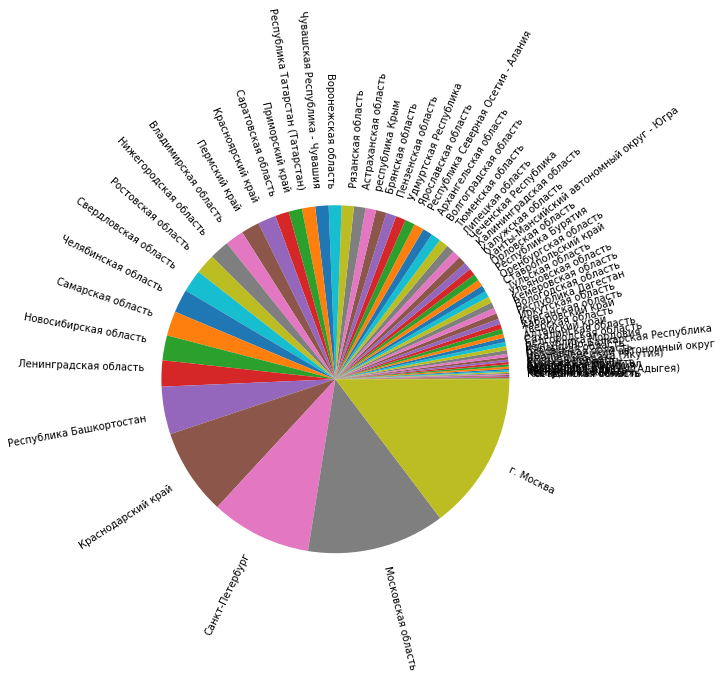

In [14]:
#Отрисуем распределения объемов застройки по регионам за 2022 год
df_for_show.show_volumes(2022)

Выводы: 
    - Лидируют по объему застройки Москва, Московская область и Санкт-Петербург
    - В некоторых регионых объемы застройки стремятся кнулю

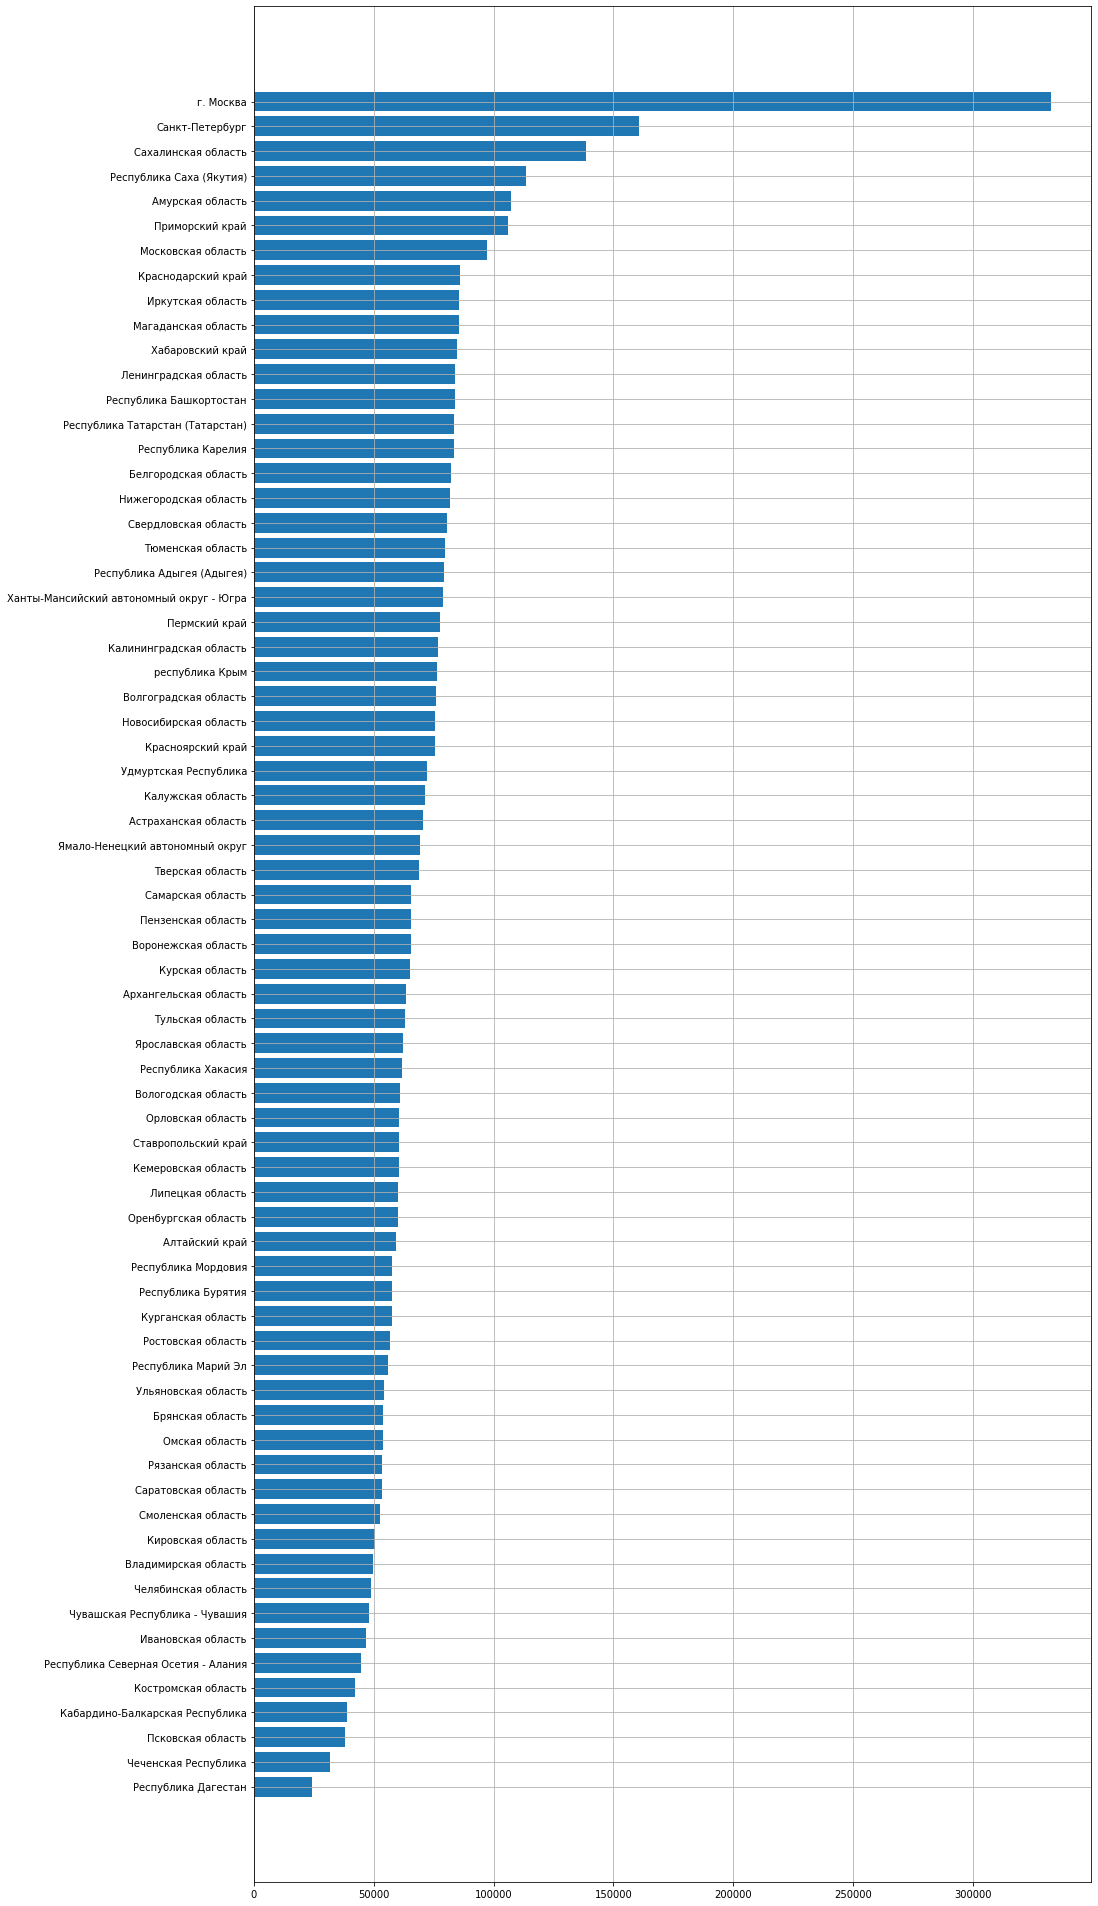

In [15]:
#отрисуем соотношение цен по регионам за 2022 год
df_for_show.show_prices(2022)

Выводы: 
    -Лидируют по средней цене за м2 Москва, Московская область и Севастополь

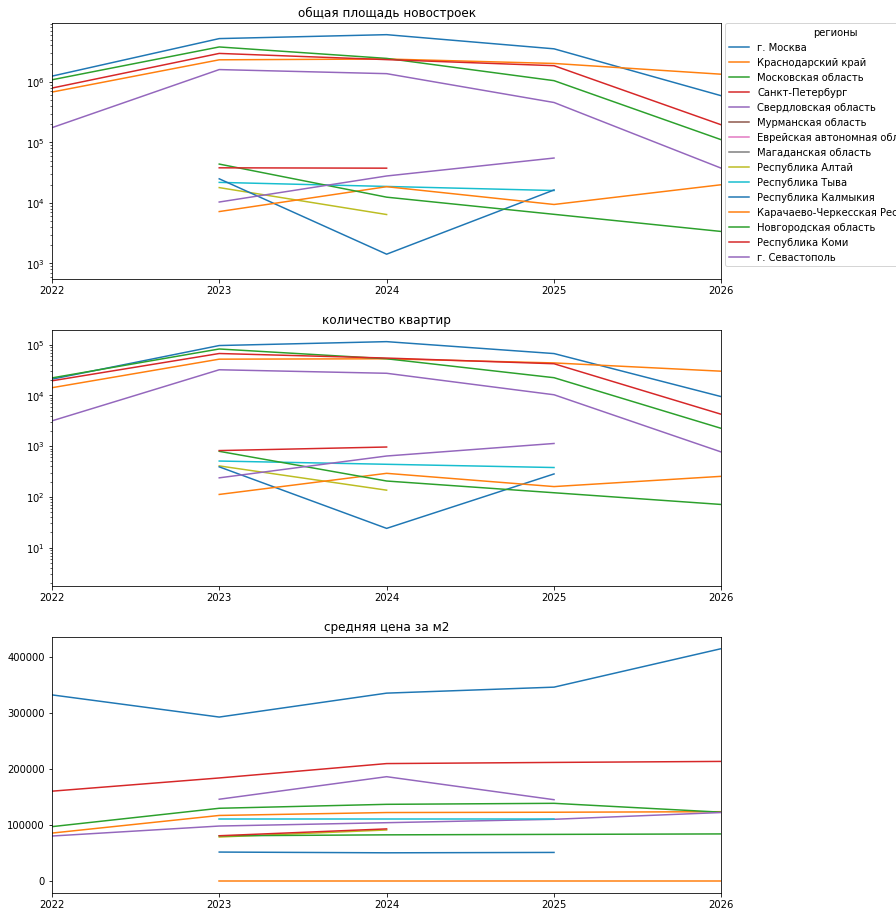

In [16]:
#отрисуем динамику объемов застройки и цен по годам 
df_for_show.show_dynamics([5,10])

Выводы:

- В наиболее активно строящихся регионах планы по застройке равномерные, без явных пиков или спадов в объемах выводимого жилья. Прослеживается уменьшение объемов к 2025-2026 году. Предположительно это объясняется тем, что - это довольно отдаленный срок, и планы на застройку еще не попали в базу.
- В наименее активно строящихся регионах застройка происходит "штучно", четкие тенденции не прослеживаются 
- Цены на жильё в Москве занчительно выше, чем в осталных регионах
- Динамика цен в целом в сторону роста. В Москве есть спад на 2023 год, но дальше тоже рост

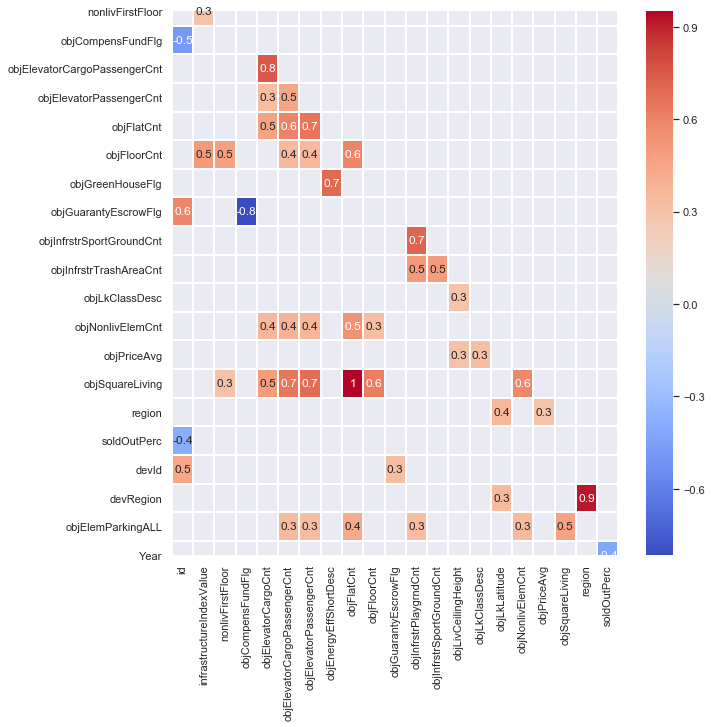

In [17]:
#отрисуем, как коррелиируются между собой параметры объектов по всем имеющимся данным
#для удобства восприятия спрячем то, что меньше 0,3
df_for_show.show_heatmap(0.3)

Выводы:

Количество общая плошадь жилых помещений в доме находятся в прямой пропорции
большинство застройщиков строят в своем регионе
Продажа через эскроу счета и гарантии от фондов находятся в сильной обратной зависимости.
Прямые связи средней силы имеются между количеством лифтов и количеством (и площадью) жилых помещений. Связь количества лифтов с этажностью здания тоже есть, но более слабая.
Прямой связью связаны количество спортивных и игровых площадок
Наблюдаестя положительная связь средней силы между энергоэффективностью дома и признаком "зеленый дом". А вот явной связи между энергоэффективностью и географической широтой не выявлено. Хотя такая связь казалась бы логичной.
есть зависимость стоимости от класса жилья, но она слабая.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


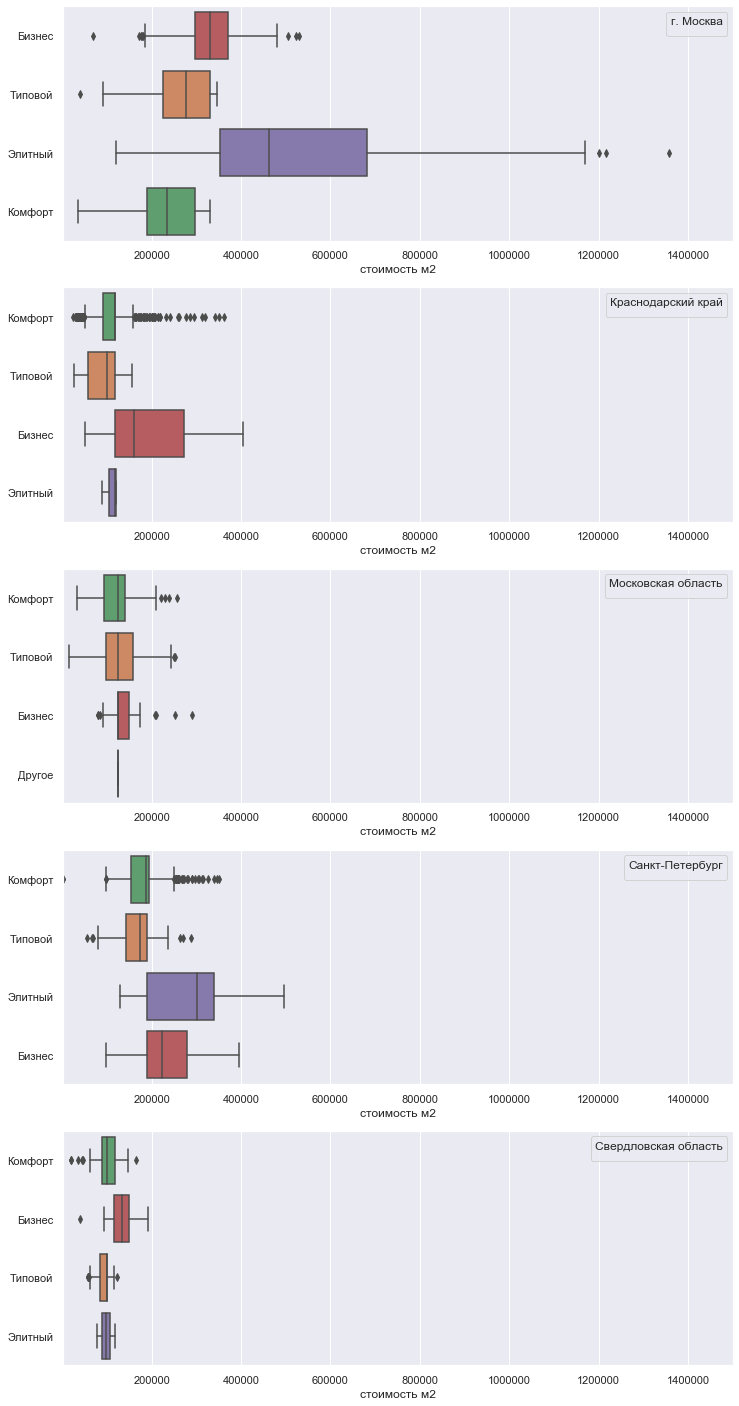

In [18]:
#визуализируем разброс средней стоимости м2 в 5 регионах с максимально активной застройкой
df_for_show.show_price_range(5)

Выводы:

Во всех рассмотренных регионах диапазоны цен на жильё разных классов во многом перекрываются. То есть, разброс стоимости м2 жилья в большей степени зависит от региона и от каких-то других факторов внутри региона, чем от класса жилья. Это говорит о том, что класс жилья не является решающим фактором в ценообразовании
Наибольший разброс по стоимости жилья наблюдается в Москве, остобенно в элитном классе. Б большом диапазоне варьируются цены на жильё бизнес-класса в Краснодарском крае, и на бизнес- и элит- классы в Санкт-Петербурге.
Интересная картина по Свердловской области. Диапазон цен на жильё комфорт класса здесь полностью перекрывает диапазоны типового и элитного классов. А медианы цен на эти три класса примерно совпадают.

['objFlatCnt', 'objFloorCnt', 'objElemParkingALL', 'objPriceAvg']


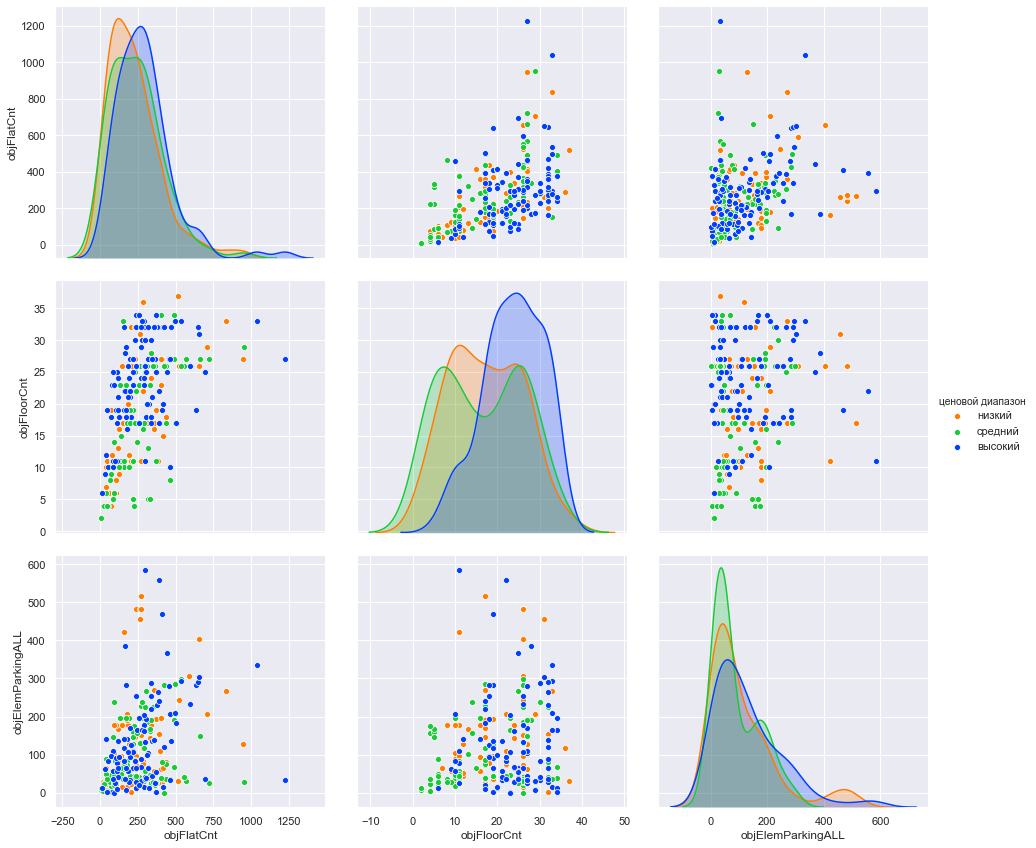

In [19]:
#Попробуем проследить зависимость между этажностью зданий, количеством квартир, количеством парковочных мест и ценой за м2.
#на примере Свердловской области
df_for_show.show_Pair_grid(66, ['objFlatCnt','objFloorCnt','objElemParkingALL'])

Выводы:

- Четких тенденций для отдельных ценовых групп не наблюдается.
- в более домах выше 30 этажей находится жилье в более высоком ценовом диапазоне 
- количество квартир в основном растет с увеличением количества этажей, для всех ценовых групп
- с увеличением количества этажей и квартир увеличивается разброс по количеству парковочных мест. При этом для многих многоэтажных и многоквартинрных домов проектируется небольшое количество парковок.